# Notebook zum Artikel Vectorisierung und Sentiment Analyse

## NLP
*Natural Language Processing*, kurz NLP, ist ein Teilgebiet der Informatik und künstlichen Intelligenz, welches sich mit der Interaktion zwischen Computern und menschlichen (natürlichen) Sprachen befasst.

Viele der uns bekannten Technologien basieren auf Anwendungen von NLP. Zum Beispiel haben viele Smartphones und Online-Suchmaschinen Textvorhersagefunktionen, die vervollständigen können, was man eingibt. Das machen sie basierend auf den Buchstaben oder Wörtern, die bereits getippt wurden. Online-Übersetzungstools basieren auf NLP-Techniken, um Wörter zwischen Sprachen zu übersetzen. Die automatische Rechtschreibprüfung ist ebenfalls ein Produkt von NLP.

## Idee des Artikels
Im Artikel sollen beispielhaft Daten, bestehend aus Reddit Kommentaren, zum Software Hersteller Microsoft vorbereitet und vektorisiert werden. Danach soll ihr Sentiment analysiert werden. Hier geht es vor allem darum die einzelnen Schritte und insbesondere das Vektorisieren näher zu betrachten. 
Dafür wird Schritt für Schritt vorgegangen und nicht auf bestehende End-to-End Tools zugegriffen.

**Dieses Notebook führt alle notwendigen Schritte wie im Artikel beschrieben durch und bildet die Grundlage für die Listings und Bilder des Artikels.**

In [1]:
# Importieren der notwendingen Module
# einzelne Objekte aus Modulen werden aus didaktischen Gründe erst vor ihrer Nutzung importiert
import pandas as pd
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Einlesen der Trainings- und Testdaten
df_train_microsoft = pd.read_csv("Reddit Data/Train/microsoft_comments_train.csv")

df_test_microsoft = pd.read_csv("Reddit Data/Test/microsoft_comments_test.csv")


In [2]:
#Entfernen ggf. vorhandener NAs aus den Trainingsdaten
df_train_microsoft.dropna(inplace=True)
display(df_train_microsoft.head(3)) #die display() Funktion ist Jupyter LAB spezifisch
#Ausgabe der Grundinformationen des Datensatzes
print(df_train_microsoft.info(), "\n")
print(df_train_microsoft.isna().sum(), "\n")

,body,created_utc,sentiment
0,I'm waiting for the hacks in the marketing dep...,2014-12-31 23:56:33,0
1,&gt;And the great thing about the web is that ...,2015-01-01 00:35:56,1
2,Many years ago I gave up giving Microsoft hint...,2015-01-01 01:55:38,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69329 entries, 0 to 69328
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body         69329 non-null  object
 1   created_utc  69329 non-null  object
 2   sentiment    69329 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ MB
None 

body           0
created_utc    0
sentiment      0
dtype: int64 



# Tokenization & spaCy


Um Textdaten richtig zu analysieren, sollten Modelle des Machine Learning in der Lage sein, Strukturen im Text zu erkennen, wie z.B. einzelne Wörter und deren Sprachanteile. Dies erreichen wir durch eine **Tokenisierung**. Hierbei wird der Korpus in **sinnvolle linguistische Einheiten**, wie Wörter oder Sätze, zerlegt und als Liste gespeichert. Die Elemente dieser Liste werden *token* genannt.

Um dies zu tun, müssen wir zuerst ein `spacy` spezifisches`.Doc`-Objekt erstellen, das den Text im Korpus enthält. Dazu nutzen wir unser `Language`-Objekt `nlp` und überreichen ihm den Text, den wir analysieren möchten.

Auf eine Tokenisierung folgt eine Textbereinigung. Textdaten können in verschiedenen Formen vorliegen: in Büchern, Zeitschriften, Webseiten, Online-Nachrichten, usw. Auch die Länge des Textes variiert: Textnachrichten sind in der Regel viel kürzer als Romane. Damit unsere Modelle mit ihnen umgehen können, müssen all diese Textformen zuerst aufbereitet und in ein Format, das aus Zahlen besteht, überführt werden. Zuvor wollen wir aber eine Bereinigung vornehmen. Dies ist notwendig, da ein Computer nicht wirklich sprechen kann und deshalb viele Aspekte der menschlichen Sprache, welche für uns Menschen sehr wichtig sind, irrelevant für einen Algorithmus sind. 

Einige Reinigungs- und Aufbereitungstechniken sind:
1. **Stoppwort-Entfernung**
2. **Entfernung von Satzzeichen**
3. **Lemmatisierung** (hier nicht durchgeführt)

In [3]:
#Importieren und Instanzieren des Englischen Language Objektes
from spacy.lang.en import English

nlp = English()

In [4]:
text = df_train_microsoft.loc[4,"body"] #Beispiel Kommentar aus dem Datensatz
print(text)

&gt;Consider Microsoft Delve, a brilliant new Office 365 tool that mines your Microsoft data, such as emails, social networks and corporate documents, to recommend content to you and make your workday more efficient. 

Not sure why TechCrunch thinks data mining all your information is what people want when they say they want to be secure against spying. Spying includes advertising companies, something companies don't seem to grasp. 


In [5]:
## "nlp" Objekt wird genutzt um ein Doc Objekt mit linguistischer Annotation und Tokens zu kreieren
my_doc = nlp(text)

##Punctuation (Satzzeichen)
#Entfernen von Tokens, die ein Satzzeichen sind
my_doc_no_punct = [token for token in my_doc if token.is_punct == False]

# Erstellen einer Liste aus Tokens im String Format
token_list = [token.text for token in my_doc_no_punct]
    

##Stopwords (Stoppworte)
#Erstellen einer Stopwords Liste aus dem nlp Objekt
stopwords = nlp.Defaults.stop_words 

# Erstellen einer Liste von Tokens ohne Stoppworte
filtered_sentence = [token for token in token_list if token not in stopwords]

# Nutzung von `re.sub()` um die gt; zu entfernen (überbleibsel von "&gt;" das für ">" steht)
# (im Artikel nicht explizit beschrieben)
filtered_sentence = " ".join(filtered_sentence)
filtered_sentence = re.sub('gt;','',filtered_sentence)

print("Rohtext Tokenisiert: \n",my_doc)
print("\nNach Satzzeichenentfernung: \n",my_doc_no_punct)
print("\nTokens im String Format: \n",token_list,"\n")
print("Nach dem Entfernen von Stoppworten: \n",filtered_sentence)   


Rohtext Tokenisiert: 
 &gt;Consider Microsoft Delve, a brilliant new Office 365 tool that mines your Microsoft data, such as emails, social networks and corporate documents, to recommend content to you and make your workday more efficient. 

Not sure why TechCrunch thinks data mining all your information is what people want when they say they want to be secure against spying. Spying includes advertising companies, something companies don't seem to grasp. 

Nach Satzzeichenentfernung: 
 [gt;Consider, Microsoft, Delve, a, brilliant, new, Office, 365, tool, that, mines, your, Microsoft, data, such, as, emails, social, networks, and, corporate, documents, to, recommend, content, to, you, and, make, your, workday, more, efficient, 

, Not, sure, why, TechCrunch, thinks, data, mining, all, your, information, is, what, people, want, when, they, say, they, want, to, be, secure, against, spying, Spying, includes, advertising, companies, something, companies, do, n't, seem, to, grasp]

Tokens im

## Erstellung einer Funktion für die oben gezeigten Schritte

In [6]:
def text_cleaner(sentence, nlp = English()):
    """
    Tokenizes text, removes punctuations and stopwords.
    
    Input
    sentence: string containing words
    nlp: spacy Language-Object, default: English()
    Output
    clean_doc: string containing tokens, with no stopwords,punctuation, double spaces etc.
    """
    # Create the Doc object named `text` from `sentence` using `nlp()`
    doc = nlp(sentence)
    
    #remove punctuation
    doc_no_punct = [token for token in doc if token.is_punct == False]

    # Create list of word tokens
    doc_token_list = [token.text for token in doc_no_punct]
    
    #remove stopwords
    stopwords = nlp.Defaults.stop_words 

    doc_no_stopwords = [token for token in doc_token_list if token not in stopwords] 

    doc_no_stopwords = " ".join(doc_no_stopwords)
    # Use `re.sub()` to substitute multiple spaces or dots`[\.\s]+` to single space `' '`
    doc_no_stopwords = re.sub('gt;','',doc_no_stopwords)
    clean_doc  = re.sub('[\.\s]+', ' ', doc_no_stopwords)
    
    return clean_doc

### Testen der Funktion

In [7]:
print(df_train_microsoft.loc[4, "body"], "\n")
print("Cleaned: \n",text_cleaner(df_train_microsoft.loc[4, "body"]))

&gt;Consider Microsoft Delve, a brilliant new Office 365 tool that mines your Microsoft data, such as emails, social networks and corporate documents, to recommend content to you and make your workday more efficient. 

Not sure why TechCrunch thinks data mining all your information is what people want when they say they want to be secure against spying. Spying includes advertising companies, something companies don't seem to grasp.  

Cleaned: 
 Consider Microsoft Delve brilliant new Office 365 tool mines Microsoft data emails social networks corporate documents recommend content workday efficient Not sure TechCrunch thinks data mining information people want want secure spying Spying includes advertising companies companies grasp


## Vorbereiten aller Kommentarspalten in den DataFrames für Vectorisierung 

In [8]:
#Erstellen einer "body_clean" Spalte aus der "body" Spalte durch die oben definierte Funktion
df_train_microsoft.loc[:, 'body_clean'] = df_train_microsoft.loc[:, 'body'].apply(text_cleaner)
display(df_train_microsoft.head())

,body,created_utc,sentiment,body_clean
0,I'm waiting for the hacks in the marketing dep...,2014-12-31 23:56:33,0,I waiting hacks marketing department change co...
1,&gt;And the great thing about the web is that ...,2015-01-01 00:35:56,1,And great thing web embed links talk And thank...
2,Many years ago I gave up giving Microsoft hint...,2015-01-01 01:55:38,1,Many years ago I gave giving Microsoft hints I...
3,Microsoft releases patches on Tuesday.,2015-01-01 02:14:01,0,Microsoft releases patches Tuesday
4,"&gt;Consider Microsoft Delve, a brilliant new ...",2015-01-01 02:17:48,1,Consider Microsoft Delve brilliant new Office ...


## Erstellen eines Feature-Vektors und Target-Vektors aus dem DataFrame 

In [9]:
features_microsoft = df_train_microsoft.loc[:, 'body_clean']
target_microsoft = df_train_microsoft.loc[:, 'sentiment']

# Vektorisierung
## Bag of Words
Die Methode *bag of words* (BoW) stellt Wörter in einem **Korpus** auf Basis der Frequenz des Wortes in jedem Text dar. Ein BoW-Algorithmus nimmt alle im Korpus vorhandenen eindeutigen Wörter und stellt jeden einzelnen Text dar, basierend darauf, wie oft ein Wort in diesem Text erscheint. Der Name (zu deutsch etwa Wörtersack) ergibt sich dadurch, dass die Reihenfolge und Struktur der Wörter im Text ignoriert wird. Es geht nur darum, ob ein Wort im Text enthalten ist, und nicht darum, wo sich dieses im Text befindet. 



Um die BoW-Vektorisierung anzuwenden, verwenden wir den *transformer* `CountVectorizer` aus `sklearn.feature_extraction.text` ([Link zur Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html?highlight=countvectorizer#sklearn.feature_extraction.text.CountVectorizer)).

In [10]:
#Importieren und Anwenden des sklearn-Objekts
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

features_bow_microsoft = count_vectorizer.fit_transform(features_microsoft)
type(features_bow_microsoft) #Output liegt als Sparse-Matrix vor

scipy.sparse.csr.csr_matrix

### Betrachten des BOW-Vektors anhand eines Beispiels

Da die Sparse-Matrix nicht einfach einsehbar ist müssen einige Schritte durchgeführt werden um einen lesbaren DataFrame zu erhalten.

In [11]:
#Extrahieren der features-names (alle Tokens) für die Bennenung der DataFrame-Spalten
bow_microsoft_features_names = count_vectorizer.get_feature_names() 
len(bow_microsoft_features_names) #Anzahl der Tokens im Vektor

64098

In [12]:
## Variante ohne spezielle pandas Methoden
# bow_microsoft_array = features_bow_microsoft.toarray()
# bow_df = pd.DataFrame(bow_microsoft_array, columns=bow_microsoft_features_names)

#Erstellen des DataFrames aus der Sparse-Matrix mit dafür vorgesehenen pandas Funktionen
bow_df = pd.DataFrame.sparse.from_spmatrix(features_bow_microsoft, columns=bow_microsoft_features_names)
bow_df.head()

,00,000,0000,00000000,000000000000,00000001,0000002,000001,000005,000005531,...,разведки,росси,рственный,служба,федера,ции,ಠ_ಠ,드래고니카,라그나로크,온라인
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Etwas deutlicher wird das Ganze wenn man sich den DataFrame für bestimmte Worte anschaut.

Wie erwartet ist das Wort microsoft in jeder Nachricht vorhanden, nach diesem Wort haben wir die Kommentare des Subreddits für diesen DataFrame durchsucht.

In [13]:
bow_df.loc[:5, ['secure','microsoft','patches']]

,secure,microsoft,patches
0,0,1,0
1,0,5,0
2,0,2,0
3,0,1,1
4,1,2,0
5,0,2,0


## Term frequency-inverse document frequency Methode (TF-IDF)

Während die BoW-Methode mit dem `CountVectorizer` Wörter anhand ihrer Häufigkeit im Text vektorisiert, berücksichtigt die *Term Frequency-Inverse Document Frequency* (**TF-IDF**) Vektorisierung die *Relevanz* eines Wortes. 

Um die Relevanz eines Wortes zu bestimmen, berücksichtigt TF-IDF, wie der Name schon sagt, zwei Dinge:

1. Wie oft ein **Wort** in einer **einzelnen Nachricht** erscheint, bezogen auf die Anzahl der Wörter in derselben **Nachricht** (*term frequency*, das **TF** in **TF-IDF**). 


\begin{equation*}
\mathrm{TF}\left( \textbf{Token}, \textbf{Text} \right) = \frac{\mathrm{Anzahl \, des  \textbf{ Tokens} \,in\, einem\, \textbf{Text}}}{\mathrm{Anzahl\, aller\, Tokens\, im\, gleichen\,\textbf{Text}}}
\end{equation*}

2. Wie oft ein **Wort** im gesamten **Korpus** erscheint, im Verhältnis zur **Größe des Korpus** (*inverse document frequency*, das **IDF** in **TF-IDF**).

\begin{equation*}
\mathrm{IDF}\left(\textbf{Token}, \textbf{Korpus}\right) = \ln\left( \frac{\mathrm{Anzahl \, der \,\textbf{Texte}\, im \, \textbf{Korpus}}}{\mathrm{Anzahl \, der \, \textbf{Texte}, \, die \, den \, \textbf{Token} \, enthalten}}\right)
\end{equation*}

Hier handelt es sich um einen *natürlichen Logarithmus*. Der **TF-IDF**-Wert von einem **Wort** in einer **Nachricht** im **Korpus** ist definiert als Produkt von **TF** und **IDF**.

\begin{equation*}
\mathrm{TF\text{-}IDF} (\textbf{Token},\textbf{Text}, \textbf{Korpus}) = \mathrm{TF}(\textbf{Token},\textbf{Text}) \,\cdot \, \mathrm{IDF}(\textbf{Token}, \textbf{Korpus})
\end{equation*}

Je mehr **Nachrichten** existieren, in welchen das **Wort** enthalten ist, desto weniger wertvoll ist dieses **Wort** für die Unterscheidung von Textarten. Der **TF-IDF** von einem solchen **Wort** würde klein sein. Ein wichtiges **Wort** wäre eines, welches nur sehr selten im gesamten **Korpus** vorkommt. 



<img src="tfidf-Graph.jpg">





`sklearn` bietet uns wieder einen *transfromer* an, der die TF-IDF-Vektorisierung für uns übernimmt. Er heißt `TfidfVectorizer` und befindet sich auch in `sklearn.feature_extraction.text` ([Link zur Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidf#sklearn.feature_extraction.text.TfidfVectorizer)).

In [14]:
# Import und Anwendung des TfidfVectorizers 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

features_tfidf_microsoft = tfidf_vectorizer.fit_transform(features_microsoft)
type(features_tfidf_microsoft) #Output ist wieder eine Sparse-Matrix

scipy.sparse.csr.csr_matrix

### Betrachten des TF-IDF Vektors anhand eines Beispiels

In [15]:
tfidf_microsoft_features_names = tfidf_vectorizer.get_feature_names() 
len(tfidf_microsoft_features_names)

64098

In [16]:
#Umwandlung in einen DataFrame, um Einsicht in die Daten zu erhalten
#Für die reine Analyse nicht notwendig
tfidf_df = pd.DataFrame.sparse.from_spmatrix(features_tfidf_microsoft, columns=tfidf_microsoft_features_names)
tfidf_df

,00,000,0000,00000000,000000000000,00000001,0000002,000001,000005,000005531,...,разведки,росси,рственный,служба,федера,ции,ಠ_ಠ,드래고니카,라그나로크,온라인
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
tfidf_df.loc[:5, ['secure','microsoft','patches']]

,secure,microsoft,patches
0,0.000000,0.037804,0.00000
1,0.000000,0.067418,0.00000
2,0.000000,0.073409,0.00000
3,0.000000,0.088466,0.52097
4,0.140447,0.053628,0.00000
5,0.000000,0.044029,0.00000


## Einblicke in die IDF-Werte
Das Attribut `tfidf_vectorizer.idf_` gibt die IDF-Werte jedes *token* an. Hier betrachten wir den maximalen und minimalen IDF-Wert im Dokument.

In [18]:
idf_values = tfidf_vectorizer.idf_
print("Maximaler IDF Wert: ", max(idf_values))
print("Minimaler IDF Wert: ", min(idf_values))

Maximaler IDF Wert:  11.453485811376591
Minimaler IDF Wert:  1.0


In [19]:
print("IDF Wert von 'microsoft': ", idf_values[tfidf_microsoft_features_names.index("microsoft")]) #low as expected

IDF Wert von 'microsoft':  1.0


In [20]:
print("IDF Wert von 'secure': ", idf_values[tfidf_microsoft_features_names.index("secure")])

IDF Wert von 'secure':  5.2378782126213155


In [21]:
print("IDF Wert von 'patches': ", idf_values[tfidf_microsoft_features_names.index("patches")])

IDF Wert von 'patches':  5.888965404053898


## Sentiment Analyse mit unserem eigenen Modell

Die Trainingsdaten wurden mit VADER analyisert.

"VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains."

Um die grundlegenden Schritte die Tools wie VADER für uns übernehmen zu verstehen, sind wir hier durch die einzelnen Schritte gegangen um unsere selbstaufbereiteten Daten und einen simplen Klassifikationsalgorithmus für die Sentiment Analyse zu nutzen.

Der letzte Schritt ist das Trainieren und Tunen eines Machine Learning Modells.



### Kurzer Einblick in die Verteilung der Sentiment Klassen

In [22]:
df_train_microsoft.loc[:, 'sentiment'].value_counts()

 1    36690
-1    23922
 0     8717
Name: sentiment, dtype: int64

Wie unschwer zu erkennen ist, sind die Klassen nicht gleichverteilt. Positives Sentiment überwiegt, neutrales ist relativ selten. Dies mag auch an den ungleichen Cut-Off Intervallen liegen, die VADER vorschlägt.

## Klassifikationsmodell

Für die Klassifikation nutzen wir Multinomial Naive Bayes. Dieser Algorithmus kann mit den vorliegenden Vektoren schnell trainiert werden und liefert passable Ergebnisse. Andere Algorithmen mögen performanter sein, benötigen aber deutlich längere Trainingszeiten.

Weiterhin wird Kreuzvalidierung genutzt um die Performance der Modelle unde Vektorisierungsarten zu testen. Da die Klassen nicht ausgeglichen sind dienen uns der F1 Wert, die Präzision und Recall (Sensitivität) in ihrer gewichteten Form als Metriken.

In [23]:
# Importieren der Notwendingen Objekte und Funktionen aus sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

In [24]:
# Instanzieren des Modells
clf = MultinomialNB()

#Kreuzvalidierung (5-Fach) der BOW-Methode
cv_results_bow = cross_validate(estimator = clf,
                            X=features_bow_microsoft,
                            y=target_microsoft,
                           scoring=["precision_weighted","recall_weighted","f1_weighted"])
#Kreuzvalidierung (5-Fach) der TF-IDF-Methode
cv_results_tfidf = cross_validate(estimator = clf,
                            X=features_tfidf_microsoft,
                            y=target_microsoft,
                           scoring=["precision_weighted","recall_weighted","f1_weighted"])

#Errechnung der durchschnittlichen Werte für jede Metrik (über alle Kreuzvalidierungen hinweg)
bow_precision = cv_results_bow["test_precision_weighted"].mean()
bow_recall = cv_results_bow["test_recall_weighted"].mean()
bow_f1 = cv_results_bow["test_f1_weighted"].mean()

tfidf_precision = cv_results_tfidf["test_precision_weighted"].mean()
tfidf_recall = cv_results_tfidf["test_recall_weighted"].mean()
tfidf_f1 = cv_results_tfidf["test_f1_weighted"].mean()

In [25]:
print(f"Precision BOW (Nach Klassen Gewichtet): {bow_precision}")
print(f"Recall BOW (Nach Klassen Gewichtet): {bow_recall}")
print(f"F1 BOW (Nach Klassen Gewichtet): {bow_f1}")
print(f"Precision TF-IDF(Nach Klassen Gewichtet): {tfidf_precision}")
print(f"Recall TF-IDF (Nach Klassen Gewichtet): {tfidf_recall}")
print(f"F1 TF-IDF (Nach Klassen Gewichtet): {tfidf_f1}")

Precision BOW (Nach Klassen Gewichtet): 0.6293708855444472
Recall BOW (Nach Klassen Gewichtet): 0.6478529185300405
F1 BOW (Nach Klassen Gewichtet): 0.6222384806840553
Precision TF-IDF(Nach Klassen Gewichtet): 0.6471353916284108
Recall TF-IDF (Nach Klassen Gewichtet): 0.5716221800241547
F1 TF-IDF (Nach Klassen Gewichtet): 0.4583746525218597


Anhand der Ergebnisse, erkennt man schnell, dass der BOW Ansatz bessere Ergebnisse liefert als TF-IDF.

## Hyperparameter



Bisher wurden die Vectorizer mit ihren Standard-Parametern genutzt. Es kann sich allerdings lohnen diese zu verändern, um zum Beispiel besser Performance in der Klassifikation zu erreichen. Die wichtigsten Parameter sind hierbei: min_df, max_df und ngram_range.

**min_df** : Beim Aufbau des Korpus werden Tokens ignoriert, deren Häufigkeit im Text strikt unter dem hier angegebenen Schwellenwert liegt. Der Standardwert ist 1, es werden also alle Tokens entfernt, die nur einmal im Text vorkommen. Wenn wir uns auf häufigere Tokens fokussieren wollen kann es sich lohnen diesen Parameter höher zu setzen.

**max_df** : Beim Aufbau des Korpus werden Tokens ignoriert, deren Häufigkeit im Text strikt über dem hier angegebenen Schwellenwert liegt. Der Standardwert ist 1, es werden also alle Tokens entfernt, die mehr als einmal im Text vorkommen. Da min_df und max_df in engem Zusammenhang stehen sollten diese Parameter immer zusammen in sinnvollen Schritten angepasst werden.

**ngram_range** : Ein Tupel mit der unteren und oberen Grenze des Bereichs der n-Werte für verschiedene zu extrahierende n-Gramme (n-grams). Ein Unigramm (ngram_range = (1,1)) wäre ein einzelner Token. Es wird also wie zuvor beschrieben die Häufigkeit jedes Tokens ermittelt. Sollen auch Wortkombinationen gezählt werden kann z.B. ngram_range = (1,2) spezifiziert werden. Jetzt werden einzelne Tokens und Token-Gruppen mit 2 Tokens (Bigramme) extrahiert und gezählt. Der Standardwert ist hier (1,1), es werden also nur einzelne Tokens extrahiert, für die Sentiment Analyse kann es sich allerdings auch anbieten Wortgruppen (z.B. not very good) zu betrachten. Wir werden verschiedene ngram_ranges für unsere Analyse ausprobieren.

Weiterhin interessant sind die Parameter max_features und stop_words. Durch ersteres kann die Anzahl der Tokens im Vektor durch einen Cut-off-Wert auf häufig vorkommende Begriffe beschränkt werden. Alternativ ist es möglich, noch mehr (domänenspezifische) Stoppwörter zu deklarieren und diese an stop_words zu geben. Beide Optionen reduzieren die Dimension des Vektorraums, so wird weniger Speicher benötigt und Berechnungen verlaufen schneller. Die inhaltlichen Ergebnisse werden hierdurch oft wenig verändert, denn die Abstandsmetrik im Vektorraum sorgt dafür, dass seltene Tokens ohnehin wenig Gewicht haben, und Stoppwörter durch die beschriebene TF/IDF-Transformation unterdrückt werden. 

Um unsere Klassifikation zu verbessern nutzen wir hier die Parameter max_features und ngram_range.
Mit GridSearchCV durchsuchen wir einen Parameterraum systematisch nach der besten Kombination. Hierfür müssen wir den Vectorizer allerdings zunächst mit dem Multinomial Naive Bayes Classifier in einer Pipeline zusammenfassen.

In [26]:
#Import von Pipeline und GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [27]:
#Erstellen der Pipelines für beide Methoden
bow_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
    ])

tfidf_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
    ])

In [28]:
#Festlegen der zu testenden Parameter
param_search_space = {
    'vect__ngram_range': ((1, 1), (1, 2),(2,2),(1,3)),  # unigrams only,unigrams or bigrams,bigrams only,uni-,bi- or trigrams
    'vect__max_features': (None, 10000, 25000, 35000)
    }

In [29]:
#Erstellen des GridSearchCV Objektes für die BOW Pipeline und den Parameterraum
bow_grid_search = GridSearchCV(estimator = bow_pipeline, 
                               param_grid = param_search_space,
                               scoring="f1_weighted",
                               cv=5, n_jobs = -1)
#Modelfitting um die beste Parameterkombination zu bestimmen
bow_grid_search.fit(features_microsoft,target_microsoft)
bow_best_params = bow_grid_search.best_estimator_.get_params()

#Erstellen des GridSearchCV Objektes für die TF-IDF Pipeline und den Parameterraum
tfidf_grid_search = GridSearchCV(estimator = tfidf_pipeline, 
                                 param_grid = param_search_space,
                                 scoring= "f1_weighted",
                                 cv=5, n_jobs = -1)
#Modelfitting um die beste Parameterkombination zu bestimmen
tfidf_grid_search.fit(features_microsoft,target_microsoft)
tfidf_best_params = tfidf_grid_search.best_estimator_.get_params()

In [30]:
#Ausgabe der Besten F1 Werte sowie der Parameterkombination für die besten Werte
print(f"Bester BOW F1 Wert: {bow_grid_search.best_score_}")
print(f"Beste BOW Hyperparameter Kombination: {bow_best_params['steps'][0]} \n")
print(f"Bester TF-IDF F1 Wert: {tfidf_grid_search.best_score_}")
print(f"Beste TF-IDF Hyperparameter Kombination: {tfidf_best_params['steps'][0]}")

Bester BOW F1 Wert: 0.6485779176318974
Beste BOW Hyperparameter Kombination: ('vect', CountVectorizer(max_features=25000, ngram_range=(1, 2))) 

Bester TF-IDF F1 Wert: 0.5956810659045486
Beste TF-IDF Hyperparameter Kombination: ('vect', TfidfVectorizer(max_features=10000, ngram_range=(1, 3)))


## Testen der Performance des besten Vectorizers und Classifiers auf einem Testset

In [31]:
#Import des F1 scores und des classification_report für die Bewertung ohne Kreuzvalidierung
from sklearn.metrics import f1_score,classification_report

In [32]:
#Tokenisierung und Bereinigung der Testdaten
df_test_microsoft.loc[:,"body_cleaned"] = df_test_microsoft.loc[:,"body"].apply(text_cleaner)
#Erstellen des Feature- und Target-Vektors
features_test = df_test_microsoft.loc[:,"body_cleaned"]
target_test = df_test_microsoft.loc[:,"sentiment"]

In [33]:
#Nutzung der besten BOW Pipeline für die Vorhersage auf den Testdaten
bow_pipeline = bow_grid_search.best_estimator_
bow_pipeline.fit(features_microsoft,target_microsoft)
target_test_pred = bow_pipeline.predict(features_test)

bow_f1_test = f1_score(target_test,target_test_pred, average="weighted")

print(f"Testset F1 (Gewichtet nach Klassen): {bow_f1_test} \n")
print(classification_report(target_test,target_test_pred))

Testset F1 (Gewichtet nach Klassen): 0.66345570957778 

              precision    recall  f1-score   support

          -1       0.64      0.61      0.63       770
           0       0.48      0.54      0.50       337
           1       0.74      0.73      0.73      1174

    accuracy                           0.66      2281
   macro avg       0.62      0.63      0.62      2281
weighted avg       0.67      0.66      0.66      2281



In [34]:
#Beispielkommentare zur Veranschaulichung der Klassifikation
comments = ["I believe Microsoft Word is the best Text Editor", 
            "Can you explain how Access works?", 
            "The new update is full of bugs"]
comments_clean = [text_cleaner(comment) for comment in comments]
print(bow_pipeline.predict(comments_clean))

[ 1  0 -1]


## Visualisierung des Sentiments über die Zeit

Eine der Klassifikation nachgestellte Analyse könnte zum Beispiel die Visualisierung des durchschnittlichen Sentiments über einen Zeitraum sein. So könnte der Stimmungsverlauf zu einem Thema und bestimmte einschneidende Ergebnisse (wie zum Beispiel größere Bugs) nachvollzogen werden.

In [35]:
#Erstellen einer Spalte ("created_date") mit dem Datum für jeden Eintrag
df_test_microsoft["created_date"] = pd.to_datetime(df_test_microsoft["created_utc"],unit="s").dt.date

In [36]:
#Berechnung des Mittelwerts des Sentiments für jedes Datum innerhalb der Testdaten (01.21-05.21)
avg_sentiment_by_date = df_test_microsoft.groupby("created_date")["sentiment"].mean()
avg_sentiment_by_date

created_date
2020-12-31    0.500000
2021-01-01    0.304348
2021-01-02    0.333333
2021-01-03    0.275000
2021-01-04    0.363636
                ...   
2021-04-26    0.357143
2021-04-27    0.194444
2021-04-28    0.043478
2021-04-29    0.303030
2021-04-30    0.477273
Name: sentiment, Length: 100, dtype: float64

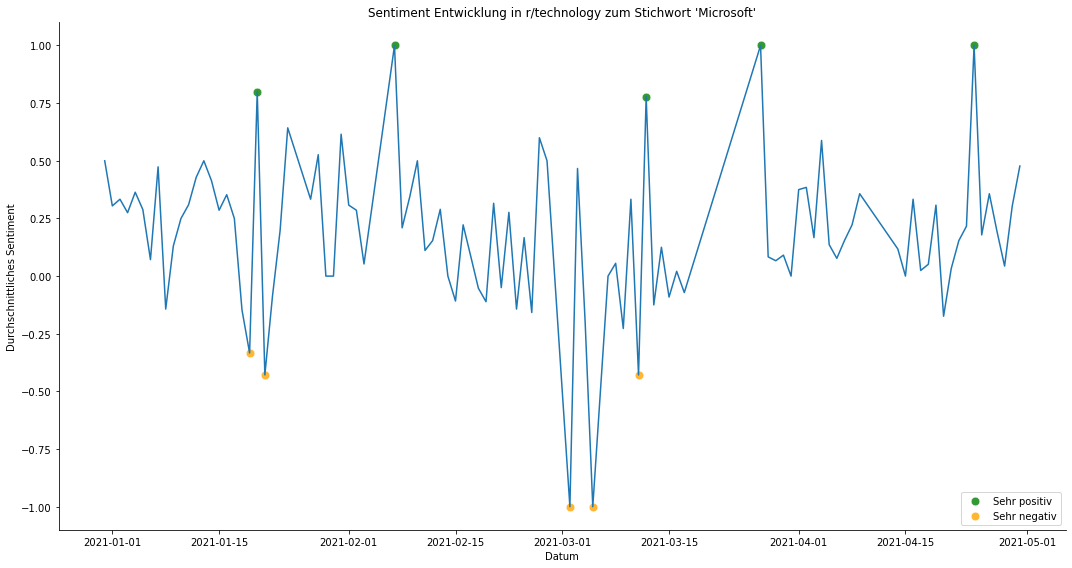

In [37]:
#Visualisierung des durchschnittlichen Sentiments pro Tag über den gesamten Zeitraum
fig,ax = plt.subplots(figsize=(15,8))
#Liniendiagramm für das durchschnittliche Sentiment
sns.lineplot(data=avg_sentiment_by_date,ax=ax)
#Kennzeichnung der 5 negativsten und 5 positivsten Tage im Zeitraum
sns.scatterplot(data=avg_sentiment_by_date.nlargest(n=5),ax=ax, color = "green",alpha=0.8,s=75, label = "Sehr positiv")
sns.scatterplot(data=avg_sentiment_by_date.nsmallest(n=5),ax=ax, color = "orange",alpha=0.8,s=75, label = "Sehr negativ")
#Formatierung und Beschriftung der Grafik
ax.set(title="Sentiment Entwicklung in r/technology zum Stichwort 'Microsoft'",
        xlabel="Datum",ylabel="Durchschnittliches Sentiment")
plt.legend(loc=4)
sns.despine()
plt.tight_layout()
plt.savefig("Sentiment_Entwicklung.png")

## Fazit

Unser eigenes Modell macht einen passablen Job. Die gewichteten Metriken sind für solch ein einfaches Modell zufriedenstellend, nur mit der Neutralen Klasse hat das Modell noch seine Probleme.

Wahrscheinlich wären wir mit einem Modell wie VADER oder spaCy etwas erfolgreicher. Dennoch zeigt unser Versuch, dass wir relativ einfache Prinzipien nutzen können um Erkenntnissen zu finden.